In [1]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install fastapi
!pip install uvicorn
!pip install nest_asyncio
!pip install python-multipart
import nest_asyncio
nest_asyncio.apply()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 1.9 MB/s eta 0:00:00


In [3]:
!pip install flask-ngrok

In [4]:
!pip install pytorch-forecasting

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.9/181.9 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 52.1 MB/s eta 0:00:00


In [5]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.8 MB/s eta 0:00:00


In [6]:
%load_ext tensorboard

In [7]:
import os
import torch
import shutil
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
import pytorch_lightning as pl

from sklearn.preprocessing import MinMaxScaler
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import RMSE
from torchmetrics import MeanAbsoluteError

In [8]:
# 데이터 경로 설정
data_path = "/content/drive/MyDrive/종설프1_5팀/전처리.ipynb/final_preprocessed_format.csv"

# 데이터 로드
df_total = pd.read_csv(data_path)

# 스케일링
scaler = MinMaxScaler()
df_total['feed_pressure'] = scaler.fit_transform(df_total[['feed_pressure']])

# 시간 인덱스 추가 (필요하다면 데이터셋에 이미 포함되어 있는 time_idx 확인)
if 'time_idx' not in df_total.columns:
    df_total['time_idx'] = range(len(df_total))

# 그룹 ID 설정 (단일 시계열일 경우 고정값 사용)
if 'group' not in df_total.columns:
    df_total["group"] = "series"

# max_encoder_length와 max_prediction_length 설정
total_data_length = len(df_total)
max_encoder_length = max(10, total_data_length // 10)
max_prediction_length = 1

print(f"Max encoder length: {max_encoder_length} entries")
print(f"Max prediction length: {max_prediction_length} entries")

Max encoder length: 5594 entries
Max prediction length: 1 entries


### TimeSeriesDataSet 생성
TimeSeriesDataSet을 사용해 데이터를 생성합니다. 여기에는 타겟, 그룹화 방식, 그리고 변동하는 시계열 컬럼을 정의합니다.


In [9]:
# 학습 및 검증 데이터 분할 (80% 학습, 20% 검증)
train_size = int(total_data_length * 0.8)
df_train = df_total.iloc[:train_size]
df_val = df_total.iloc[train_size:]

# TimeSeriesDataSet 설정
training = TimeSeriesDataSet(
    df_train,  # 학습 데이터만 사용
    time_idx="time_idx",
    target="feed_pressure",  # 타겟 변수
    group_ids=["group"],  # 그룹화
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    time_varying_known_reals=["time_idx"],  # 시간 관련 변수
    time_varying_unknown_reals=["feed_pressure"],  # 예측 대상 변수
    target_normalizer=GroupNormalizer(transformation="relu")  # 정규화
)

# 검증 데이터셋 생성
validation = TimeSeriesDataSet.from_dataset(training, df_val)

### DataLoader 생성
DataLoader를 생성하여 모델이 데이터를 학습할 수 있도록 준비합니다.

### Temporal Fusion Transformer 모델 생성
Temporal Fusion Transformer 모델을 생성하여 데이터셋을 학습할 준비를 합니다.

### LightningModule 정의 및 Trainer 설정
PyTorch Lightning을 이용하여 모델 학습을 보다 쉽게 관리할 수 있도록 합니다.


In [10]:
best_params = {
    "learning_rate": 0.0013095831847880091,
    "hidden_size": 29,
    "attention_head_size": 3,
    "dropout": 0.34884270911702864,
    "hidden_continuous_size": 24
}

In [11]:
# 데이터 로더 생성
train_dataloader = training.to_dataloader(train=True, batch_size=32, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=32, num_workers=0)

from torchmetrics import MeanAbsoluteError

# Define the loss function
loss = MeanAbsoluteError()

# Temporal Fusion Transformer 모델 생성
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=best_params["learning_rate"],
    hidden_size=best_params["hidden_size"],
    attention_head_size=best_params["attention_head_size"],
    dropout=best_params["dropout"],
    hidden_continuous_size=best_params.get("hidden_continuous_size", 16),
    loss=loss,
    log_interval=10,
    reduce_on_plateau_patience=5,
    optimizer="adam"
)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [12]:
# TFTWrapper 클래스 수정
class TFTWrapper(pl.LightningModule):
    def __init__(self, tft_model):
        super().__init__()
        self.tft_model = tft_model
        self.train()  # 학습 모드로 설정

    def forward(self, x):
        # 모든 입력 데이터를 모델의 디바이스로 이동
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        x = {key: value.to(device) if isinstance(value, torch.Tensor) else value for key, value in x.items()}

        # 모델의 모든 파라미터를 디바이스로 이동
        self.tft_model.to(device)

        return self.tft_model(x)

    def training_step(self, batch, batch_idx):
        # 학습 모드로 전환
        self.train()
        x, y = batch

        # 입력 데이터와 타겟을 모델의 디바이스로 이동
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        x = {key: value.to(device) if isinstance(value, torch.Tensor) else value for key, value in x.items()}
        y = y[0] if isinstance(y, tuple) else y
        y = y.to(device)

        # 예측 및 손실 계산
        y_hat = self(x)["prediction"]
        loss = self.tft_model.loss(y_hat, y)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch

        # 입력 데이터와 타겟을 모델의 디바이스로 이동
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        x = {key: value.to(device) if isinstance(value, torch.Tensor) else value for key, value in x.items()}
        y = y[0] if isinstance(y, tuple) else y
        y = y.to(device)

        # 예측 및 손실 계산
        y_hat = self(x)["prediction"]
        loss = self.tft_model.loss(y_hat, y)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.03)
        lr_scheduler = {
            'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5),
            'monitor': 'val_loss'
        }
        return [optimizer], [lr_scheduler]

In [13]:
# Google Drive에 저장된 체크포인트 경로
checkpoint_path = "/content/drive/MyDrive/종설프1_5팀/checkpoints/tft-best.ckpt"

# 모델 학습 및 체크포인트 설정
local_checkpoint_dir = "/content/checkpoints/"
drive_checkpoint_dir = "/content/drive/MyDrive/종설프1_5팀/checkpoints/"
os.makedirs(local_checkpoint_dir, exist_ok=True)
os.makedirs(drive_checkpoint_dir, exist_ok=True)

# 기존 체크폰트 파일 삭제 함수
def delete_existing_checkpoints(checkpoint_dir):
    if os.path.exists(checkpoint_dir):
        for filename in os.listdir(checkpoint_dir):
            file_path = os.path.join(checkpoint_dir, filename)
            try:
                if os.path.isfile(file_path):
                    os.remove(file_path)
                    print(f"Deleted checkpoint file: {file_path}")
            except Exception as e:
                print(f"Failed to delete {file_path}: {e}")


# 가장 최근 체크포인트 찾기
def get_latest_checkpoint(checkpoint_dir):
    if os.path.exists(checkpoint_dir):
        checkpoints = [os.path.join(checkpoint_dir, f) for f in os.listdir(checkpoint_dir) if f.endswith(".ckpt")]
        if checkpoints:
            return max(checkpoints, key=os.path.getctime)  # 가장 최근 파일 반환
    return None

### Optuna 활용

In [14]:
def objective(trial):
    # 하이퍼파라미터 정의
    hidden_size = trial.suggest_int("hidden_size", 8, 64)
    attention_head_size = trial.suggest_int("attention_head_size", 1, 4)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    hidden_continuous_size = trial.suggest_int("hidden_continuous_size", 8, 32)

    # TemporalFusionTransformer 모델 생성
    tft = TemporalFusionTransformer.from_dataset(
        training,
        learning_rate=learning_rate,
        hidden_size=hidden_size,
        attention_head_size=attention_head_size,
        dropout=dropout,
        hidden_continuous_size=hidden_continuous_size,
        loss=loss,
        log_interval=10,
        reduce_on_plateau_patience=3
    )

    # LightningModule로 감싸기
    wrapped_tft = TFTWrapper(tft)

    # EarlyStopping 설정
    early_stop_callback = EarlyStopping(
        monitor="val_loss",
        min_delta=1e-4,
        patience=3,
        verbose=True,
        mode="min"
    )

    # Checkpoint 콜백 설정
    checkpoint_callback = ModelCheckpoint(
        monitor="val_loss",
        mode="min",
        save_top_k=1,
        dirpath=f"{local_checkpoint_dir}/trial_{trial.number}",
        filename="tft-{epoch:02d}-{val_loss:.2f}"
    )

    # Logger 설정
    logger = TensorBoardLogger("lightning_logs", name=f"optuna_trial_{trial.number}")

    # Trainer 설정
    trainer = Trainer(
        max_epochs=10,
        accelerator="gpu",
        devices=1,
        callbacks=[checkpoint_callback, early_stop_callback],
        logger=logger
    )

    # 모델 학습
    trainer.fit(
        model=wrapped_tft,  # LightningModule로 감싼 모델 사용
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader
    )

    # 검증 손실 반환
    val_loss = trainer.callback_metrics.get("val_loss", None)
    if val_loss is None:
        raise ValueError("Validation loss is not available.")
    return val_loss.item()

In [15]:
# 2. Optuna 스터디 생성
study = optuna.create_study(direction="minimize")

# 3. 최적화 실행
study.optimize(objective, n_trials=3)

# 4. 최적화 결과 사용
best_params = study.best_params

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=best_params["learning_rate"],
    hidden_size=best_params["hidden_size"],
    attention_head_size=best_params["attention_head_size"],
    dropout=best_params["dropout"],
    hidden_continuous_size=best_params["hidden_continuous_size"],  # 최적화된 값 반영
    loss=loss,
    log_interval=10,
    reduce_on_plateau_patience=5
)

[I 2024-12-09 05:19:02,642] A new study created in memory with name: no-name-37c7236b-83de-47ae-9b6e-31e218349d1a
/usr/local/lib/python3.10/dist-packages/pytorch_forecasting/models/temporal_fusion_transformer/__init__.py:171: UserWarning: In pytorch-forecasting models, on versions 1.1.X, the default optimizer defaults to 'adam', if pytorch_optimizer is not installed, otherwise it defaults to 'ranger' from pytorch_optimizer. From version 1.2.0, the default optimizer will be 'adam' regardless of whether pytorch_optimizer is installed, in order to minimize the number of dependencies in default parameter settings. Users who wish to ensure their code continues using 'ranger' as optimizer should ensure that pytorch_optimizer is installed, and set the optimizer parameter explicitly to 'ranger'.
  super().__init__(loss=loss, logging_metrics=logging_metrics, **kwargs)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
I

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 32. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 27. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.061


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 3 records. Best score: 0.061. Signaling Trainer to stop.
[I 2024-12-09 06:17:16,194] Trial 0 finished with value: 0.09866740554571152 and parameters: {'hidden_size': 22, 'attention_head_size': 4, 'dropout': 0.47562391768279677, 'learning_rate': 0.0035345106609614815, 'hidden_continuous_size': 16}. Best is trial 0 with value: 0.09866740554571152.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.135


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.063 >= min_delta = 0.0001. New best score: 0.072


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.011 >= min_delta = 0.0001. New best score: 0.061


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 3 records. Best score: 0.061. Signaling Trainer to stop.
[I 2024-12-09 07:49:51,652] Trial 1 finished with value: 0.07657073438167572 and parameters: {'hidden_size': 45, 'attention_head_size': 1, 'dropout': 0.2780334372377269, 'learning_rate': 0.001982480242982696, 'hidden_continuous_size': 26}. Best is trial 1 with value: 0.07657073438167572.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                      

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.079


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 3 records. Best score: 0.079. Signaling Trainer to stop.
[I 2024-12-09 08:43:57,980] Trial 2 finished with value: 0.09938887506723404 and parameters: {'hidden_size': 16, 'attention_head_size': 2, 'dropout': 0.30888774692429355, 'learning_rate': 0.0024471017290105283, 'hidden_continuous_size': 31}. Best is trial 1 with value: 0.07657073438167572.


In [25]:
print(study.best_params)

{'hidden_size': 45, 'attention_head_size': 1, 'dropout': 0.2780334372377269, 'learning_rate': 0.001982480242982696, 'hidden_continuous_size': 26}


## 모델 학습

<span style="color:red;">주의: 체크포인트 삭제!</span>

In [17]:
# LightningModule로 감싸기
wrapped_tft = TFTWrapper(tft).to("cuda")  # GPU로 이동

# Trainer 설정
trainer = Trainer(
    max_epochs=50,
    accelerator="gpu",
    devices=1,
    callbacks=[
        ModelCheckpoint(
            dirpath=local_checkpoint_dir,
            filename="tft-best",
            monitor="val_loss",
            mode="min",
            save_top_k=1,
            save_last=True
        ),
        EarlyStopping(
            monitor="val_loss",
            min_delta=1e-4,
            patience=10,
            verbose=True,
            mode="min"
        )
    ],
    logger=TensorBoardLogger("lightning_logs", name="tft_final"),
    gradient_clip_val=0.3,
    precision=32,
)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [18]:
# 기존 체크포인트에서 로드 여부 확인 및 학습 실행
delete_checkpoints = input("기존 체크포인트 파일을 삭제하시겠습니까? (y/n): ").lower()

if delete_checkpoints == 'y':
    print("기존 체크포인트 파일을 삭제합니다.")
    delete_existing_checkpoints(local_checkpoint_dir)
    delete_existing_checkpoints(drive_checkpoint_dir)

    # 새 학습 시작
    trainer.fit(
        model=wrapped_tft,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader
    )

else:
    print("기존 체크포인트를 유지합니다.")
    latest_checkpoint = get_latest_checkpoint(local_checkpoint_dir)

    if latest_checkpoint:
        print(f"기존 체크포인트에서 로드합니다: {latest_checkpoint}")

        # 체크포인트에서 모델 로드
        loaded_tft = TemporalFusionTransformer.load_from_checkpoint(
            latest_checkpoint,
            map_location=torch.device('cuda')
        )

        # TFTWrapper로 래핑 및 GPU로 이동
        wrapped_tft = TFTWrapper(tft_model=loaded_tft).to('cuda')

        # 기존 체크포인트에서 로드한 모델로 학습 재개
        trainer.fit(
            model=wrapped_tft,
            train_dataloaders=train_dataloader,
            val_dataloaders=val_dataloader
        )

    else:
        print("체크포인트가 없습니다. 새로 학습을 시작합니다.")

        # 새 학습 시작
        trainer.fit(
            model=wrapped_tft,
            train_dataloaders=train_dataloader,
            val_dataloaders=val_dataloader
        )

기존 체크포인트 파일을 삭제하시겠습니까? (y/n): y
기존 체크포인트 파일을 삭제합니다.


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                      | Params | Mode 
----------------------------------------------------------------
0 | tft_model | TemporalFusionTransformer | 118 K  | train
----------------------------------------------------------------
118 K     Trainable params
0         Non-trainable params
118 K     Total params
0.475     Total estimated model params size (MB)
172       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.088


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.024 >= min_delta = 0.0001. New best score: 0.065


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.063


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.062


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 10 records. Best score: 0.062. Signaling Trainer to stop.


In [19]:
# 학습 종료 후 가장 좋은 체크포인트 경로 출력
print(f"Best checkpoint saved at: {checkpoint_callback.best_model_path}")

Best checkpoint saved at: 


In [20]:
# 학습이 끝난 후 로컬 체크포인트를 Google Drive로 복사
shutil.copyfile(
    os.path.join(local_checkpoint_dir, "tft-best.ckpt"),
    os.path.join(drive_checkpoint_dir, "tft-best.ckpt")
)

'/content/drive/MyDrive/종설프1_5팀/checkpoints/tft-best.ckpt'

## 서버구축

In [ ]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip


--2024-12-09 04:50:28--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 35.71.179.82, 13.248.244.96, 75.2.60.68, ...
Connecting to bin.equinox.io (bin.equinox.io)|35.71.179.82|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13921656 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.28M  8.64MB/s    in 1.5s    

2024-12-09 04:50:30 (8.64 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13921656/13921656]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [ ]:
!./ngrok authtoken cr_2pQNo2X1zqJCJbgu2vzvGoq8ubY

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


## 모델 다시 로드

In [24]:
# Google Drive에 저장된 체크포인트 경로
checkpoint_path = "/content/drive/MyDrive/종설프1_5팀/checkpoints/tft-best.ckpt"

loaded_tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=best_params["learning_rate"],
    hidden_size=best_params["hidden_size"],
    attention_head_size=best_params["attention_head_size"],
    dropout=best_params["dropout"],
    hidden_continuous_size=best_params["hidden_continuous_size"],  # 최적화된 값 반영
    loss=loss,
    log_interval=10,
    reduce_on_plateau_patience=5
)

# 체크포인트 로드
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cuda'))  # GPU로 로드

# state_dict 키 이름 수정
state_dict = checkpoint["state_dict"]
new_state_dict = {k.replace("tft_model.", ""): v for k, v in state_dict.items()}  # 접두사 제거

# 수정된 state_dict를 모델에 로드
loaded_tft.load_state_dict(new_state_dict)
loaded_tft.to('cuda')  # GPU로 이동
loaded_tft.eval()

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
/usr/local/lib/python3.10/dist-packages/pytorch_forecasting/models/temporal_fusion_transformer/__init__.py:171: UserWarning: In pytorch-forecasting models, on versions 1.1.X, the default optimizer defaults to 'adam', if pytorch_optimizer is not installed, otherwise it defaults to 'ranger' from pytorch_optimizer. From version 1.2.0, the default optimizer will be 'adam' regardless of whether pytorch_optimizer is installed, in order to minimize the number of 

TemporalFusionTransformer(
  	"attention_head_size":               1
  	"categorical_groups":                {}
  	"causal_attention":                  True
  	"dataset_parameters":                {'time_idx': 'time_idx', 'target': 'feed_pressure', 'group_ids': ['group'], 'weight': None, 'max_encoder_length': 5594, 'min_encoder_length': 5594, 'min_prediction_idx': 0, 'min_prediction_length': 1, 'max_prediction_length': 1, 'static_categoricals': [], 'static_reals': None, 'time_varying_known_categoricals': None, 'time_varying_known_reals': ['time_idx'], 'time_varying_unknown_categoricals': None, 'time_varying_unknown_reals': ['feed_pressure'], 'variable_groups': None, 'constant_fill_strategy': None, 'allow_missing_timesteps': False, 'lags': None, 'add_relative_time_idx': False, 'add_target_scales': False, 'add_encoder_length': False, 'target_normalizer': GroupNormalizer(
  		method='standard',
  		groups=None,
  		center=True,
  		scale_by_group=False,
  		transformation='relu',
  		meth

## ROLLING 방식

In [26]:
# 'group' 컬럼 확인 및 추가
if "group" not in df_total.columns or df_total["group"].isnull().any():
    print("'group' 컬럼이 누락되었거나 비어 있습니다. 기본 그룹 값을 설정합니다.")
    df_total["group"] = "series"  # 기본 그룹 값 설정

In [27]:
# 'group' 컬럼 고유성 확인
if df_total["group"].nunique() > 1:
    print(f"'group' 컬럼에 {df_total['group'].nunique()}개의 고유 값이 있습니다. 모델이 단일 그룹을 예상할 수 있으니 확인하세요.")

# Rolling Prediction 실행 전에 데이터 유효성 확인
if len(df_total) < max_encoder_length:
    print(
        f"데이터셋 길이 ({len(df_total)})가 max_encoder_length ({max_encoder_length})보다 짧습니다. "
        "데이터를 패딩하여 문제를 해결합니다."
    )
    # 필요한 패딩 길이 계산
    padding_length = max_encoder_length - len(df_total)
    last_row = df_total.iloc[-1]
    padding = pd.DataFrame([last_row] * padding_length)

    # time_idx를 늘리기
    padding["time_idx"] = range(df_total["time_idx"].max() + 1, df_total["time_idx"].max() + 1 + padding_length)

    # 패딩 추가
    df_total = pd.concat([df_total, padding], ignore_index=True)
    print(f"데이터셋이 {len(df_total)}로 패딩되었습니다.")


In [28]:
# rolling_predict_batch 수정
def rolling_predict_batch(
    model, train_dataset, max_encoder_length, scaler, condition_value=17, tolerance=0.1, batch_size=1, device="cuda"
):
    """
    Rolling 방식으로 한 번에 batch_size만큼 예측을 수행하며 조건 만족 시까지 반복합니다.

    Args:
        model: PyTorch 모델.
        train_dataset: 학습에 사용된 데이터셋 (DataFrame 형태).
        max_encoder_length: 롤링 윈도우의 길이.
        scaler: MinMaxScaler (스케일링 복원을 위해 필요).
        condition_value: 예측이 중단되는 조건 값 (예: 17).
        tolerance: 조건 값에 대한 허용 오차.
        batch_size: 한 번에 예측할 예측 길이 (기본: 1).
        device: 사용할 디바이스 (default: "cuda").

    Returns:
        predictions (list): 예측된 값의 리스트.
    """
    model = model.to(device)
    model.eval()

    # Initialize with the first encoder window from the training data
    input_data = train_dataset.iloc[:max_encoder_length].copy()
    predictions = []

    # Add group column if missing
    if "group" not in input_data.columns:
        input_data["group"] = "series"

    step = 0
    while True:
        try:
            # Create TimeSeriesDataSet for rolling prediction
            rolling_dataset = TimeSeriesDataSet(
                data=input_data,
                time_idx="time_idx",
                target="feed_pressure",
                group_ids=["group"],
                max_encoder_length=max_encoder_length,
                max_prediction_length=batch_size,
                static_categoricals=[],
                time_varying_known_reals=["time_idx"],
                time_varying_unknown_reals=["feed_pressure"],
                target_normalizer=GroupNormalizer(transformation="relu"),
                min_encoder_length=1,
                allow_missing_timesteps=True,
            )

            rolling_dataloader = rolling_dataset.to_dataloader(train=False, batch_size=1)

            # Predict the next value
            with torch.no_grad():
                input_batch = next(iter(rolling_dataloader))
                input_batch = {key: value.to(device) for key, value in input_batch[0].items()}
                batch_predictions = model(input_batch)["prediction"].cpu().numpy().squeeze()

            # Restore the scaled prediction to original scale
            batch_predictions_actual = scaler.inverse_transform(batch_predictions.reshape(-1, 1)).flatten()
            predictions.extend(batch_predictions_actual)

            print(f"Step {step}: Predicted Value = {batch_predictions_actual[0]}")

            # Check if the prediction meets the condition
            if abs(batch_predictions_actual[0] - condition_value) <= tolerance:
                print(f"Condition met: Predicted value is within tolerance of {condition_value}. Stopping prediction.")
                break

            # Update rolling input data with the new predicted value
            new_time_idx = input_data["time_idx"].iloc[-1] + 1
            new_row = {
                "time_idx": new_time_idx,
                "feed_pressure": batch_predictions_actual[0],
                "group": "series",
            }
            input_data = pd.concat([input_data.iloc[1:], pd.DataFrame([new_row])], ignore_index=True)

            step += 1

        except Exception as e:
            print(f"Error at step {step}: {e}")
            break

    return predictions

In [29]:
rolling_predictions = rolling_predict_batch(
    model=wrapped_tft,
    train_dataset=df_total,
    max_encoder_length=max_encoder_length,
    scaler=scaler,
    condition_value=17,
    tolerance=0.1,
    batch_size=1,
    device="cuda",
)

print("Final Predictions:", rolling_predictions)

Step 0: Predicted Value = 10.237747192382812
Step 1: Predicted Value = 10.672417640686035
Step 2: Predicted Value = 10.972491264343262
Step 3: Predicted Value = 11.223711013793945
Step 4: Predicted Value = 11.447588920593262
Step 5: Predicted Value = 11.65350341796875
Step 6: Predicted Value = 11.846532821655273
Step 7: Predicted Value = 12.029794692993164
Step 8: Predicted Value = 12.205366134643555
Step 9: Predicted Value = 12.374713897705078
Step 10: Predicted Value = 12.538917541503906
Step 11: Predicted Value = 12.698843955993652
Step 12: Predicted Value = 12.85512924194336
Step 13: Predicted Value = 13.008280754089355
Step 14: Predicted Value = 13.158711433410645
Step 15: Predicted Value = 13.3067626953125
Step 16: Predicted Value = 13.452680587768555
Step 17: Predicted Value = 13.59671401977539
Step 18: Predicted Value = 13.739073753356934
Step 19: Predicted Value = 13.879939079284668
Step 20: Predicted Value = 14.0194673538208
Step 21: Predicted Value = 14.157796859741211
Step 

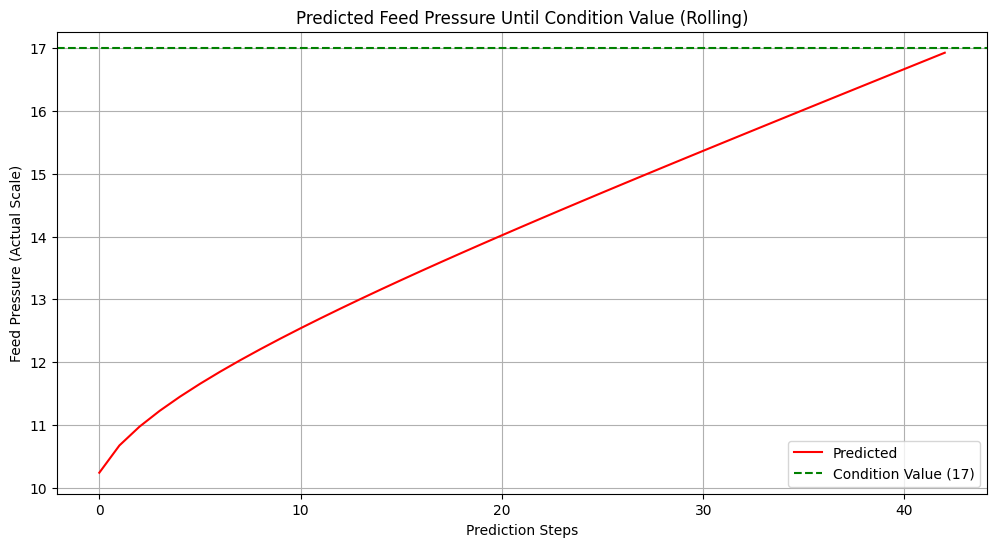

In [30]:
# 결과 시각화 함수
def plot_rolling_predictions(predicted_values, condition_value=17):
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(predicted_values)), predicted_values, label="Predicted", linestyle="-", color="red")
    plt.axhline(y=condition_value, color="green", linestyle="--", label=f"Condition Value ({condition_value})")
    plt.xlabel("Prediction Steps")
    plt.ylabel("Feed Pressure (Actual Scale)")
    plt.title("Predicted Feed Pressure Until Condition Value (Rolling)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Rolling Predictions 그래프 호출
plot_rolling_predictions(rolling_predictions, condition_value=17)


###  Api System

In [ ]:
from fastapi import FastAPI, UploadFile, File
from pydantic import BaseModel
import pandas as pd
import torch
from pytorch_lightning import Trainer
from sklearn.preprocessing import MinMaxScaler
import os
from matplotlib import pyplot as plt

# Import necessary modules and classes from your existing code
# from your_code import TemporalFusionTransformer, rolling_predict_batch, plot_rolling_predictions

# Initialize FastAPI app
app = FastAPI()

# Global variables
tft_model = None  # Placeholder for the trained model
scaler = MinMaxScaler()
max_encoder_length = 10
condition_value = 17

# Define request model for predict endpoint
class PredictRequest(BaseModel):
    condition_value: float = 17.0
    tolerance: float = 0.1
    batch_size: int = 1

# Define the model loading function
def load_model(model_path, training_dataset, best_params):
    global tft_model

    # TemporalFusionTransformer model creation
    tft_model = TemporalFusionTransformer.from_dataset(
        training_dataset,
        learning_rate=best_params["learning_rate"],
        hidden_size=best_params["hidden_size"],
        attention_head_size=best_params["attention_head_size"],
        dropout=best_params["dropout"],
        hidden_continuous_size=16,
        loss=torch.nn.MSELoss(),
        log_interval=10,
        reduce_on_plateau_patience=3
    )

    # Load checkpoint
    checkpoint = torch.load(model_path, map_location=torch.device('cuda'))
    state_dict = checkpoint["state_dict"]
    new_state_dict = {k.replace("tft_model.", ""): v for k, v in state_dict.items()}

    # Load state dict
    tft_model.load_state_dict(new_state_dict)
    tft_model.to('cuda')
    tft_model.eval()
    print("Model loaded successfully.")

# Define the predict endpoint
@app.post("/predict")
async def predict(request: PredictRequest, file: UploadFile = File(...)):
    global tft_model, scaler

    # Ensure the model is loaded
    if tft_model is None:
        return {"error": "Model not loaded. Please load the model first."}

    # Read the uploaded CSV file into a DataFrame
    try:
        df = pd.read_csv(file.file)
    except Exception as e:
        return {"error": f"Failed to load CSV file: {str(e)}"}

    # Data preprocessing
    if "feed_pressure" not in df.columns:
        return {"error": "CSV file must contain a 'feed_pressure' column."}

    df["feed_pressure"] = scaler.transform(df[["feed_pressure"]])  # Apply existing scaler
    df["time_idx"] = range(len(df))
    if "group" not in df.columns:
        df["group"] = "series"

    # Validate dataset length for rolling prediction
    if len(df) < max_encoder_length:
        padding_length = max_encoder_length - len(df)
        last_row = df.iloc[-1]
        padding = pd.DataFrame([last_row] * padding_length)
        padding["time_idx"] = range(df["time_idx"].max() + 1, df["time_idx"].max() + 1 + padding_length)
        df = pd.concat([df, padding], ignore_index=True)
        print(f"Dataset padded to {len(df)} rows.")

    # Perform rolling predictions
    predictions = rolling_predict_batch(
        model=tft_model,
        train_dataset=df,
        max_encoder_length=max_encoder_length,
        scaler=scaler,
        condition_value=request.condition_value,
        tolerance=request.tolerance,
        batch_size=request.batch_size,
        device="cuda"
    )

    return {"predictions": predictions}

# Define the root endpoint
@app.get("/")
def read_root():
    return {"message": "TFT API is running. Use /predict endpoint to make predictions."}

# Define a model loading endpoint
@app.post("/load_model")
def load_model_endpoint(model_path: str, training_dataset_path: str, best_params: dict):
    try:
        # Load training dataset
        training_df = pd.read_csv(training_dataset_path)

        # Preprocess the training dataset
        training_df["feed_pressure"] = scaler.fit_transform(training_df[["feed_pressure"]])
        training_df["time_idx"] = range(len(training_df))
        if "group" not in training_df.columns:
            training_df["group"] = "series"

        # Create training TimeSeriesDataSet
        training_dataset = TimeSeriesDataSet(
            training_df,
            time_idx="time_idx",
            target="feed_pressure",
            group_ids=["group"],
            max_encoder_length=max_encoder_length,
            max_prediction_length=1,
            static_categoricals=[],
            time_varying_known_reals=["time_idx"],
            time_varying_unknown_reals=["feed_pressure"],
            target_normalizer=GroupNormalizer(transformation="relu")
        )

        # Load the model
        load_model(model_path, training_dataset, best_params)

        return {"message": "Model loaded successfully."}
    except Exception as e:
        return {"error": f"Failed to load model: {str(e)}"}

In [ ]:
# 앱 실행 코드
import uvicorn
uvicorn.run(app, host="0.0.0.0", port=8000)

INFO:     Started server process [3501]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)
INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [3501]
